# TIME-BASED TRAIN / VAL / TEST + BASELINE MODEL

In [1]:
import os
from math import sqrt

import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 100)

## Step 1: Load Dataset

In [3]:
df = pd.read_parquet("../data/processed/clv_modeling_table.parquet")

In [4]:
df.head()

,customer_id,last_purchase,recency_days,frequency,total_revenue,avg_order_value,first_purchase,tenure_days,active_months,purchase_velocity,avg_gap_days,std_gap_days,clv_6m
0,12346.0,2011-01-18 10:01:00,133,1,77183.60,77183.600000,2011-01-18 10:01:00,133,1,1.0,999.000000,0.000000,0.00
1,12347.0,2011-04-07 10:43:00,54,3,1823.43,21.707500,2010-12-07 14:57:00,175,3,1.0,1.433735,9.325016,2261.75
2,12348.0,2011-04-05 10:47:00,56,3,1487.24,53.115714,2010-12-16 19:09:00,166,3,1.0,4.037037,15.166972,310.00
3,12350.0,2011-02-02 16:01:00,118,1,334.40,19.670588,2011-02-02 16:01:00,118,1,1.0,0.000000,0.000000,0.00
4,12352.0,2011-03-22 16:08:00,70,5,1561.81,41.100263,2011-02-16 12:33:00,104,2,2.5,0.918919,3.410591,944.23


In [5]:
df.shape

(2718, 13)

## Step 2: Define Time-Based Split Logic

In [6]:
df = df.sort_values("recency_days", ascending=False).reset_index(drop=True)

In [7]:
# index-based split 60/20/20

n = len(df)

train_end = int(0.6 * n)
val_end = int(0.8 * n)

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()

In [8]:
len(train_df), len(val_df), len(test_df)

(1630, 544, 544)

In [9]:
train_df["recency_days"].min(), train_df["recency_days"].max()

(34, 181)

In [10]:
val_df["recency_days"].min(), val_df["recency_days"].max()

(14, 34)

In [11]:
test_df["recency_days"].min(), test_df["recency_days"].max()

(0, 14)

## Step 3: Define Features & Target

In [12]:
target = "clv_6m"

features = [
    "recency_days",
    "frequency",
    "total_revenue",
    "avg_order_value",
    "tenure_days",
    "active_months",
    "purchase_velocity",
    "avg_gap_days",
    "std_gap_days",
]

In [13]:
X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

X_test = test_df[features]
y_test = test_df[target]

## Step 4: Metric Function

In [14]:
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)

    mae = mean_absolute_error(y_true, y_pred)
    return {"rmse": rmse, "mae": mae}

## Step 5: Baseline Model: Linear Regression

In [15]:
baseline_model = Pipeline(
    steps=[("scaler", StandardScaler()), ("model", LinearRegression())]
)

In [16]:
PROJECT_ROOT = os.path.abspath("C:/Users/diana/jupyter_notebooks/clv-prediction")

In [17]:
os.chdir(PROJECT_ROOT)

In [18]:
print(os.getcwd())

C:\Users\diana\jupyter_notebooks\clv-prediction


In [19]:
# MLFlow setup

mlflow.set_tracking_uri(f"sqlite:///{PROJECT_ROOT}/mlflow.db")
mlflow.set_experiment("clv_prediction_baseline")

2026/01/04 14:23:08 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/04 14:23:08 INFO mlflow.store.db.utils: Updating database tables
2026/01/04 14:23:08 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/04 14:23:08 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/04 14:23:08 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/04 14:23:08 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/diana/jupyter_notebooks/clv-prediction/mlruns/1', creation_time=1767438995907, experiment_id='1', last_update_time=1767438995907, lifecycle_stage='active', name='clv_prediction_baseline', tags={}>

In [20]:
with mlflow.start_run(run_name="linear_regression_baseline"):
    baseline_model.fit(X_train, y_train)

    val_preds = baseline_model.predict(X_val)
    test_preds = baseline_model.predict(X_test)

    val_metrics = regression_metrics(y_val, val_preds)
    test_metrics = regression_metrics(y_test, test_preds)

    mlflow.log_params({"model_type": "linear_regression", "scaling": "standard"})

    mlflow.log_metrics(
        {
            "val_rmse": val_metrics["rmse"],
            "val_mae": val_metrics["mae"],
            "test_rmse": test_metrics["rmse"],
            "test_mae": test_metrics["mae"],
        }
    )

    mlflow.sklearn.log_model(baseline_model, name="model")

val_metrics, test_metrics

({'rmse': 7488.803773322124, 'mae': 1353.1676697016537},
 {'rmse': 9043.063278754658, 'mae': 2053.153662733101})

## Step 6: Interpret Baseline

In [21]:
# extract coefficients
coefs = pd.Series(
    baseline_model.named_steps["model"].coef_, index=features
).sort_values(key=np.abs, ascending=False)

coefs

total_revenue        821.000341
avg_order_value     -701.592998
frequency            162.933242
purchase_velocity   -150.918444
std_gap_days         -93.435816
active_months         75.775426
recency_days         -61.644714
tenure_days           57.712639
avg_gap_days          34.811589
dtype: float64

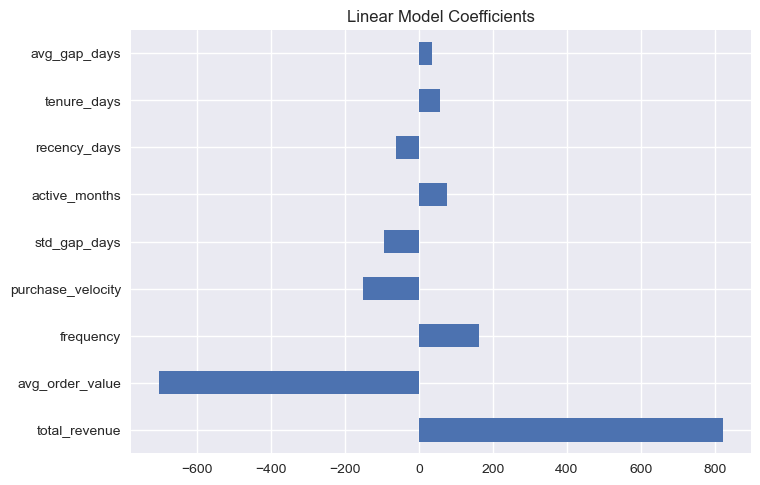

In [22]:
coefs.plot(kind="barh")
plt.title("Linear Model Coefficients")
plt.show()

**Conclusion**:

Initial baseline on raw CLV shows very large RMSE due to heavy-tailed target distribution. This motivates log-transformation of the target and the use of non-linear models.

## Step 7: Log-Transformed CLV Baseline

In [23]:
train_df["clv_6m_log"] = np.log1p(train_df["clv_6m"])
val_df["clv_6m_log"] = np.log1p(val_df["clv_6m"])
test_df["clv_6m_log"] = np.log1p(test_df["clv_6m"])

In [24]:
y_train_log = train_df["clv_6m_log"]
y_val_log = val_df["clv_6m_log"]
y_test_log = test_df["clv_6m_log"]

In [25]:
log_baseline_model = Pipeline(
    [("scaler", StandardScaler()), ("model", LinearRegression())]
)

In [26]:
with mlflow.start_run(run_name="linear_regression_log_target"):
    log_baseline_model.fit(X_train, y_train_log)

    val_preds_log = log_baseline_model.predict(X_val)
    test_preds_log = log_baseline_model.predict(X_test)

    # prevent exponential explosion
    MAX_LOG_CLV = y_train_log.quantile(0.995)
    val_preds_log = np.clip(val_preds_log, a_min=None, a_max=MAX_LOG_CLV)
    test_preds_log = np.clip(test_preds_log, a_min=None, a_max=MAX_LOG_CLV)

    # back to original CLV scale
    val_preds = np.expm1(val_preds_log)
    test_preds = np.expm1(test_preds_log)

    val_metrics = regression_metrics(y_val, val_preds)
    test_metrics = regression_metrics(y_test, test_preds)

    mlflow.log_params(
        {
            "model_type": "linear_regression",
            "target_transform": "log1p",
            "scaling": "standard",
            "prediction_clipping": "0.995_quantile",
        }
    )

    mlflow.log_metrics(
        {
            "val_rmse": val_metrics["rmse"],
            "val_mae": val_metrics["mae"],
            "test_rmse": test_metrics["rmse"],
            "test_mae": test_metrics["mae"],
        }
    )

    mlflow.sklearn.log_model(log_baseline_model, name="model")

val_metrics, test_metrics

({'rmse': 8388.022045785223, 'mae': 1649.5821651882377},
 {'rmse': 11129.527415349845, 'mae': 2862.1524823623604})

**Conclusion**:

A raw CLV linear regression baseline outperformed a log-transformed target baseline. This indicates that most predictive signal is already linear in engineered RFM features.

## Step 7: RandomForest Baseline (Raw CLV)

In [27]:
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1
)

In [28]:
with mlflow.start_run(run_name="random_forest_baseline"):
    rf_model.fit(X_train, y_train)

    val_preds = rf_model.predict(X_val)
    test_preds = rf_model.predict(X_test)

    val_metrics = regression_metrics(y_val, val_preds)
    test_metrics = regression_metrics(y_test, test_preds)

    mlflow.log_params(
        {
            "model_type": "random_forest",
            "n_estimators": 200,
            "max_depth": "None",
            "min_samples_leaf": 5,
        }
    )

    mlflow.log_metrics(
        {
            "val_rmse": val_metrics["rmse"],
            "val_mae": val_metrics["mae"],
            "test_rmse": test_metrics["rmse"],
            "test_mae": test_metrics["mae"],
        }
    )

    mlflow.sklearn.log_model(rf_model, name="model")

val_metrics, test_metrics

({'rmse': 8287.887131090223, 'mae': 1366.2682807225844},
 {'rmse': 10710.35537748587, 'mae': 2226.0502897408846})

**Conclusion**:

Tree-based models such as RandomForest did not significantly outperform a linear baseline, indicating that engineered RFM-style features already capture most predictive signal linearly.

## Step 8: GradientBoostingRegressor (Raw CLV)

In [29]:
gbr_model = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
)

In [30]:
with mlflow.start_run(run_name="gradient_boosting_baseline"):
    gbr_model.fit(X_train, y_train)

    val_preds = gbr_model.predict(X_val)
    test_preds = gbr_model.predict(X_test)

    val_metrics = regression_metrics(y_val, val_preds)
    test_metrics = regression_metrics(y_test, test_preds)

    mlflow.log_params(
        {
            "model_type": "gradient_boosting",
            "n_estimators": 300,
            "learning_rate": 0.05,
            "max_depth": 3,
        }
    )

    mlflow.log_metrics(
        {
            "val_rmse": val_metrics["rmse"],
            "val_mae": val_metrics["mae"],
            "test_rmse": test_metrics["rmse"],
            "test_mae": test_metrics["mae"],
        }
    )

    mlflow.sklearn.log_model(gbr_model, name="model")

val_metrics, test_metrics

({'rmse': 8525.324759668785, 'mae': 1445.3073444300514},
 {'rmse': 10896.957583930329, 'mae': 2355.659902809539})

**Conclusion**:

Multiple regression models were evaluated, including Linear Regression, RandomForest, and Gradient Boosting. Despite its simplicity, Linear Regression achieved the lowest MAE on both validation and test sets. This indicates that engineered RFM-style features capture most predictive signal linearly. More complex models did not improve generalization performance and were therefore not selected.